# [EX17] Pretrained model의 활용

#### * 목차
1. pretrained model 로딩하기    
2. pretrained model finetune & Inference 수행 & 학습 경과 시각화 비교분석   
1) pretrained model 미적용     
1-1) Inference 수행       
1-2) 학습 경과 시각화 비교분석   
2) pretrained model 적용    
2-1) Inference 수행     
2-2) 학습 경과 시각화 비교분석    
3. 결과   

## 1. pretrained model 로딩하기

### KorQuAD 데이터 로드

In [1]:
# 한국어 폰트 설치를 확인합니다.  
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

In [2]:
# imports
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:     # list 형태의 item은 첫번째 item만 출력
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [4]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

# 훈련데이터 확인
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [5]:
# 검증데이터 확인
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


### KorQuAD 데이터셋 전처리 (1) 띄어쓰기 단위 정보관리

In [6]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [7]:
# whitespace가 2개인 경우를 처리해야 함

string1 = '1839년 파우스트를 읽었다.'
string2 = '1839년  파우스트를 읽었다.'
string1[6:10], string2[7:11]

('파우스트', '파우스트')

In [8]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [9]:
# 첫번째 문장(string1)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string1)
for c, i in zip(list(string1), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'], [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [10]:
# 두번째 문장(string2)에 대해 띄어쓰기 영역 정보를 표시
word_tokens, char_to_word = _tokenize_whitespace(string2)
for c, i in zip(list(string2), char_to_word):
    print(f'\'{c}\' : {i}')

word_tokens, char_to_word

'1' : 0
'8' : 0
'3' : 0
'9' : 0
'년' : 0
' ' : 0
' ' : 0
'파' : 1
'우' : 1
'스' : 1
'트' : 1
'를' : 1
' ' : 1
'읽' : 2
'었' : 2
'다' : 2
'.' : 2


(['1839년', '파우스트를', '읽었다.'],
 [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2])

### KorQuAD 데이터셋 전처리 (2) Tokenize by Vocab

In [11]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [12]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [13]:
print(word_tokens)  # 처리해야 할 word 단위 입력

context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
context_tokens, word_to_token   # Subword 단위로 토큰화한 결과

['1839년', '파우스트를', '읽었다.']


(['▁1839', '년', '▁', '파우스트', '를', '▁읽', '었다', '.'], [0, 2, 5])

### KorQuAD 데이터셋 전처리 (3) Improve Span

In [14]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

# answer_text에 해당하는 context 영역을 정확히 찾아내야 합니다. 
assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [15]:
# context를 띄어쓰기(word) 단위로 토큰화한 결과를 살펴봅니다. 
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [16]:
# 띄어쓰기(word) 단위로 쪼개진 context(word_tokens)를 Subword로 토큰화한 결과를 살펴봅니다. 
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [17]:
# answer_start와 answer_end로부터 word_start와 word_end를 구합니다. 
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [18]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [19]:
# 실제 정답인 answer_text도 Subword 기준으로 토큰화해 둡니다. 
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [20]:
# 정답이 될수 있는 new_start와 new_end의 경우를 순회탐색합니다. 
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:   # 정답과 일치하는 경우
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


In [21]:
# context_tokens에서 char_answer의 위치를 찾아 리턴하는 함수
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [22]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

### KorQuAD 데이터셋 전처리 (4) 데이터셋 분리

In [23]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [24]:
# 전처리를 수행하여 파일로 생성합니다. 
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [25]:
def print_file(filename, count=10):
    """
    파일 내용 출력
    :param filename: 파일 이름
    :param count: 출력 라인 수
    """
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

print_file(f"{data_dir}/korquad_train.json")

{"qa_id": "6566495-0-0", "title": "파우스트_서곡", "question": ["▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "를", "▁읽고", "▁무엇을", "▁쓰고", "자", "▁", "했", "는", "가", "?"], "context": ["▁1839", "년", "▁바그너", "는", "▁괴테", "의", "▁", "파우스트", "을", "▁처음", "▁읽고", "▁그", "▁내용에", "▁마음이", "▁끌려", "▁이를", "▁소재로", "▁해서", "▁하나의", "▁교향곡", "을", "▁쓰", "려는", "▁뜻을", "▁갖는다", ".", "▁이", "▁시기", "▁바그너", "는", "▁1838", "년에", "▁빛", "▁독", "촉", "으로", "▁산", "전", "수", "전을", "▁다", "▁", "걲", "은", "▁상황이", "라", "▁좌절", "과", "▁실망", "에", "▁가득", "했으며", "▁메", "피스", "토", "펠", "레스", "를", "▁만나는", "▁", "파우스트", "의", "▁심", "경에", "▁공감", "했다고", "▁한다", ".", "▁또한", "▁파리에서", "▁아브", "네", "크의", "▁지휘", "로", "▁파리", "▁음악원", "▁관현악단", "이", "▁연주하는", "▁베토벤", "의", "▁교향곡", "▁9", "번을", "▁듣고", "▁깊은", "▁감", "명을", "▁받았는데", ",", "▁이것이", "▁이듬해", "▁1", "월에", "▁", "파우스트", "의", "▁서", "곡으로", "▁쓰여진", "▁이", "▁작품에", "▁조금", "이라도", "▁영향을", "▁끼", "쳤", "으리라", "는", "▁것은", "▁의심", "할", "▁여지가", "▁없다", ".", "▁여기", "의", "▁라", "단", "조", "▁조성", "의", "▁경우에도", "▁그의", "▁전기", "에", "▁적혀", "▁있는", 

### KorQuAD 데이터셋 전처리 (5) 데이터 로드

In [26]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [27]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__


args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [28]:
# 생성한 데이터셋 파일을 메모리에 로딩하는 함수
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                # 최대 길이내에 token이 들어가지 않은 경우 처리하지 않음
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [29]:
# train data load
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

# dev data load
dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

In [30]:
# Question과 Context가 포함된 입력데이터 1번째
train_inputs[0][0]

array([    5, 15798,    10, 28935,     9,    11, 29566,    20, 14604,
       20424,  3904,    70,    11,  4648,    10,    19,  1910,     4,
       22070,    15, 15798,    10, 28935,     9,    11, 29566,    16,
         626, 14604,    38, 14028, 11773, 13829,   384,  8376,  3021,
        1239,  6874,    16,  1687,  5958,  2694,  5061,     7,    30,
        1613, 15798,    10, 28065,    75,  4415,  1816,  4978,    27,
         347,   145,   107,  2703,   263,    11,     1,    18,  5853,
          99,  9677,    24, 11969,    13,  7595,   437,  1019,  5907,
         257,  3794,  1972,    20, 11278,    11, 29566,     9,   612,
       12631, 13214,  1732,    76,     7,   110,  8802, 17581,   354,
        9648,  2060,    21,  1682, 22110, 18164,    17, 21076, 14980,
           9,  6874,    81, 11325,  4239,  3597,  1010,  1035, 17670,
           8,  2447,  1306,    35,   443,    11, 29566,     9,   315,
       12729, 14457,    30,  7938,  3742, 10766,   634,  9971, 17590,
       19424,    10,

In [31]:
# Question을 0으로, Context를 1로 구분해 준 Segment 데이터 1번째
train_inputs[1][0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,

In [32]:
# Answer위치의 시작점과 끝점 라벨 1번째
train_labels[0][0], train_labels[1][0]

(37, 37)

### BERT의 모델 구조 : Position Embedding

In [33]:
# 유틸리티 함수들

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))


def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [34]:
# mode == "embedding" 일 경우 Token Embedding Layer 로 사용되는 layer 클래스입니다. 

class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shared Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs

In [35]:
class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: positional embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [36]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [37]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

In [38]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [39]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [40]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        """
        layer 실행
        :param enc_tokens: encoder tokens
        :param segments: token segments
        :return logits_cls: CLS 결과 logits
        :return logits_lm: LM 결과 logits
        """
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

### BERT 모델 구성

In [41]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm) # (bs, n_seq, 2)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)  # (bs, n_seq, 1), (bs, n_seq, 1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [42]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [43]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

## 2. pretrained model finetune & Inference 수행 & 학습 경과 시각화 비교분석

### 1) pretrained model 미적용

In [44]:
model = BERT4KorQuAD(config)

In [45]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [46]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [47]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0

for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 5.9460, 5.9506, acc: 0.0172, 0.0042
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0032, 0.0047


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0047, 0.0037


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9506, acc: 0.0040, 0.0040


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 5.9506, 5.9506, acc: 0.0051, 0.0025


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 5.9506, 5.9506, acc: 0.0000, 0.0018
early stopping


### 1-1) Inference 수행

In [48]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [49]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  [CLS] 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?[SEP] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 

2
질문 :  임종석이 여의도 농민 폭

81
질문 :  노아의 방주 안정성을 실험하기 위한 연구가 있다고 주장하는 단체는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  창조과학회
예측 :  [CLS] 노아의 방주 안정성을 실험하기 위한 연구가 있다고 주장하는 단체는?[SEP] 창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 

86
질문 :  1868년 게이오 4년 4월 11일 신정부 군에게 양도되기로 한 반류마루를 기상 불량 등의 이유로 연기한 후 인도를 거부한 사람은 누구인가?
지문 :  1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함

### 1-2) 학습 경과 시각화 비교분석

#### 데이터 분석 :Question

In [50]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_dev.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

0 ['▁임종', '석이', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '▁된', '▁날', '은', '?']
59 ['▁1989', '년', '▁6', '월', '▁30', '일', '▁평양', '축', '전에', '▁대표로', '▁파견', '▁된', '▁인물은', '?']
0 ['▁임종', '석이', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '된', '▁연도', '는', '?']
160 ['▁임종', '석을', '▁검거', '한', '▁장소', '는', '▁경', '희', '대', '▁내', '▁어디', '인', '가', '?']
199 ['▁임종', '석이', '▁조사를', '▁받은', '▁뒤', '▁인계', '된', '▁곳은', '▁어딘가', '?']
39 ['▁1989', '년', '▁2', '월', '▁15', '일', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '된', '▁사람의', '▁이름은', '?']
6 ['▁임종', '석이', '▁1989', '년', '▁2', '월', '▁15', '일에', '▁지명', '수', '배', '▁받은', '▁혐의', '는', '▁어떤', '▁시위를', '▁주도', '했다는', '▁것인가', '?']
46 ['▁정부의', '▁헌법', '개정', '안', '▁준비', '▁과정에', '▁대해서', '▁청와대', '▁비서', '실이', '▁아니라', '▁국무회의', '▁중심으로', '▁이뤄', '졌', '어야', '▁했다고', '▁지적', '한', '▁원', '로', '▁헌법', '학자', '는', '?']
34 ["▁'", '행', '보가', '▁비서', '▁본', '연의', '▁역할을', '▁벗어난', '다', "'", ',', "▁'", '장관', '들과', '▁내각', '이', '▁소외', '되고', 

In [51]:
# token count
dev_question_counts = [len(question) for question in questions]
dev_question_counts[:10]

[15, 14, 15, 14, 10, 19, 20, 25, 35, 16]

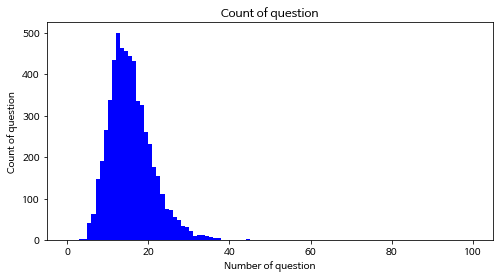

In [52]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev_question_counts, bins=100, range=[0, 100], facecolor='b', label='dev')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [53]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(dev_question_counts):4d}")
print(f"question 길이 최소:    {np.min(dev_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(dev_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(dev_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev_question_counts, 25)
percentile50 = np.percentile(dev_question_counts, 50)
percentile75 = np.percentile(dev_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      45
question 길이 최소:       3
question 길이 평균:      15.15
question 길이 표준편차:    5.33
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


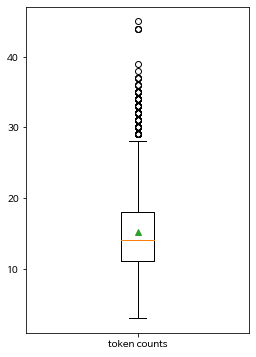

In [54]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(dev_question_counts, labels=['token counts'], showmeans=True)
plt.show()

#### 데이터 분석 : Context

In [55]:
# token count
dev_context_counts = [len(context) for context in contexts]
dev_context_counts[:10]

[207, 207, 207, 207, 207, 207, 207, 204, 204, 204]

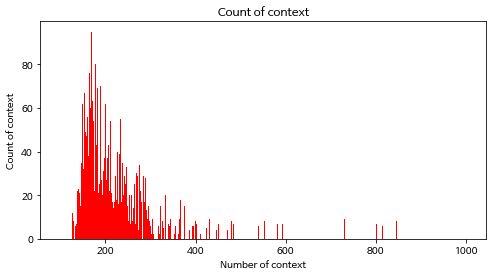

In [56]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev_context_counts, bins=900, range=[100, 1000], facecolor='r', label='dev')
# 그래프 제목
plt.title('Count of context')
# 그래프 x 축 라벨
plt.xlabel('Number of context')
# 그래프 y 축 라벨
plt.ylabel('Count of context')
plt.show()

In [57]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(dev_context_counts):4d}")
print(f"context 길이 최소:    {np.min(dev_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(dev_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(dev_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev_context_counts, 25)
percentile50 = np.percentile(dev_context_counts, 50)
percentile75 = np.percentile(dev_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    1226
context 길이 최소:     127
context 길이 평균:     231.85
context 길이 표준편차:  117.01
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   250.00
context IQR:          81.00
context MAX/100분위:  371.50


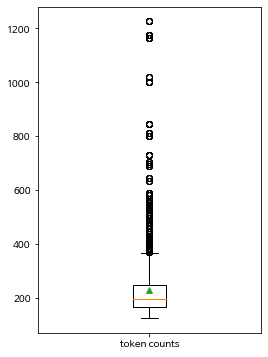

In [58]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(dev_context_counts, labels=['token counts'], showmeans=True)
plt.show()

#### 데이터 분석 : Answer

In [59]:
# token count
dev_answer_starts = token_starts
dev_answer_starts[:10]

[0, 59, 0, 160, 199, 39, 6, 46, 34, 88]

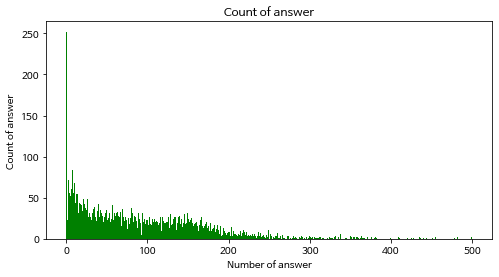

In [60]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev_answer_starts, bins=500, range=[0, 500], facecolor='g', label='dev')
# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [61]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(dev_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(dev_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(dev_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(dev_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev_answer_starts, 25)
percentile50 = np.percentile(dev_answer_starts, 50)
percentile75 = np.percentile(dev_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1192
answer 위치 최소:       0
answer 위치 평균:      93.74
answer 위치 표준편차:   90.45
answer 25/100분위:    26.00
answer 50/100분위:    75.00
answer 75/100분위:   140.00
answer IQR:         114.00
answer MAX/100분위:  311.00


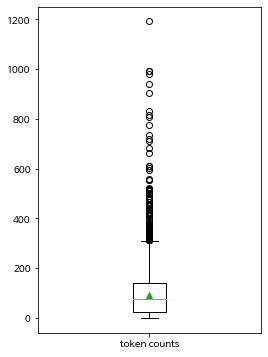

In [62]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(dev_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

### 2) pretrained model 적용

In [76]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    #  pretrained model 을 로드하기 위해 먼저 모델이 생성되어 있어야 한다.
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
    
    # checkpoint 파일로부터 필요한 layer를 불러온다. 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


In [77]:
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(20):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain2.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 5 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7783, 1.9768, acc: 0.5485, 0.5188
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.8324, 1.9946, acc: 0.5500, 0.5230
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.7016, 1.9746, acc: 0.5732, 0.5406
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.0243, 2.2803, acc: 0.5448, 0.5088


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.1308, 2.6376, acc: 0.5572, 0.5042


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 2.5279, 2.5379, acc: 0.5449, 0.5109


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 6 >> loss: 2.5038, 2.7674, acc: 0.5399, 0.5035


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 7 >> loss: 2.9123, 2.8207, acc: 0.5397, 0.5007
early stopping


### 2-1) Inference 수행

In [78]:
def do_predict(model, question, context):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param question: 입력 문자열
    :param context: 입력 문자열
    """
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))
    # print(y_start, y_end)
    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [80]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

2
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내

32
질문 :  헤이그가 군대에서 퇴역한 년도는?
지문 :  헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논쟁으로 들어갔다. 헤이그를 군사의 최상으로 밀어넣은 닉슨의 행동은 대통령의 남자들을 다양한 연방 대리법에서 권한의 직우들로 놓은 노력과 함께 일치였다. 하지만 그는 곧 백악관으로 돌아가 1973년부터 1974년까지 대통령 특별 보좌관을 지냈다. 워터게이트 사건이 일어난지 한달 후, 헤이그는 포위된 닉슨 대통령을 위한 치명적 역할을 하였다. 그일은 8월 닉슨의 사임과 제럴드 포드의 대통령으로 계승으로 이끈 협상들에서 헤이그가 수단이었던 우연이 아니었다. 곧 후에 헤이그는 미국 유럽 연합군 최고사령부의 최고 사령관으로 임명되었다. 그는 나토에서 다음 5년을 보내고 1979년 군에서 퇴역하여 미국 기술 주식 회사의 우두머리가 되었다.
정답 :  1979년
예측 :  1979년 

34
질문 :  알렉산더 헤이그는 레이건의 조언자들을 무엇이라고 묘사하였는가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서만 근심한 레이건의 가까운 조언자들을 "외교 정책의 아마추어"로 묘사하였다. 1982년 6월 25일 결국적으로 온 그의 국무장관으로서 사임은 불가능한 상황이 된 것을 끝냈다. 헤이그는 개인적 생활로 돌아갔다가 1988년 대통령 선거를 위한 공화당 후보직을 안정시키는 시도를 하는 데 충분하게 정계로 돌아갔으나 후보직을 이기는 데 성원을 가지지 않았다. 그는 외교 정책 논쟁들에 연설자로서 활동적으로 남아있었으나 그의 전념은 정치에서 개인적 생활로 옮겨졌다. 그는 Worldwide Associates Inc.의 국제적 상담 회사에 의하여 기용되었고, 그 기구의 의장과 회장이 되었다.
정답 :  외교 정책의 아마추어
예측 :  "외교 정책의 아마추어"로 

35
질문 :  헤이그가 사적생활을 하다가 정계로 돌아갔던 해는 언제인가?
지문 :  그의 편에 헤이그는 지구촌의 논점들의 국내적 정치 노력들에 관해서

66
질문 :  2012년 중국에서 노아의 방주가 발견되었다는 보도를 한 방송사는 어디인가?
지문 :  일반적으로 터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아라랏이라 불리는 하나의 산이 아니라 당시 아라랏이라고 불리던 광대한 지역의 산들을 모두 가리키는 표현이라는 주장도 나와 있으며, 또한 목재로 만들어진 방주가 현재까지 남아있을 수는 없다는 비판도 받고 있다. 예를 들어, 1955년 프랑스의 탐험가인 Fernand Navarra가 발견한 목재 파편의 경우, 스페인의 임업 연구소에서 목재의 특성을 토대로 5000년 전의 것이라고 밝히긴 했으나 그 신빙성에 문제점이 있었고 후에 방사성 동위원소 측정법 등의 첨단 과학의 도움을 받은 5개 연구소에서 모두 기원 이후의 시기로 연대를 측정했다. 2009년 뿐 아니라 거의 수년에 한번씩 어디선가 노아의 방주를 발견했다는 주장들이 제시되었지만, 심지어 같은 창조과학을 주장하는 사람들에게조차 비판받을 정도였다. 노아의 방주가 다른 여러 지방에서 발견되었다는 주장이 있으나 너무나 다양한 지방(중국, 터키, 인도 등)에 걸쳐있고, 그 주장도 각각 제각각이므로 신빙성이 없다. 예를 들자면, 중국 BTV에서는 2012년에 중국에서 노아의 방주가 발견되었다는 보도를 하였는데, 이것은 창조과학회에서 주장하는 장소와는 전혀 다른곳이기도 하며, 화석화가 진행되지 않은 나무의 존재등으로 가짜임이 밝혀졌다. 때때로 일부 "학자"라 칭하는 사람들이 이를 찾기 위해 노력한다고 주장하지만, 이는 학계에서 유사지질학으로 평가되고 있다.
정답 :  BTV
예측 :  중국 BTV 

67
질문 :  노아의 방주는 무엇으로 만들었기 때문에 현재까지 남아 있는 것이 불가능한가?
지문 :  일반적으로 터키의 아라랏 산의 경우, 실제 성경 속에 등장하는 아라랏 산은 지금 아라랏이라 불리는 하나의 산이 아니라 당시 아라랏이라고 불리던 광대한 지역의 산들을 모두 가리키는 표현이라는 주장도 나와 있으며, 또한 목재로 만들어진 방주가 현

85
질문 :  1868년 게이오 4년 4월 11일 반류마루는 누구에게 양도되기로 약속되었는가?
지문 :  1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월만에 에노모토 해군과 합류하였다. 에조치에 건너가 하코다테 전쟁에서는 에노모토(하코다테 정부) 해군의 주력함이 되었다. 영국이 기증했을 때 엠퍼러(Emperor, 기증 당시 일본의 수장은 황제가 아니라 쇼군으로 인식되고 있었기 때문에 장군을 지칭)로 명명하고 있음에서 알 수 있듯이, 쇼군용 유람 요트로 기증되었다고 생각되지만, 세상이 그것을 허락하지 않았다. 아이러니하게도, 군함에 통합되어 실제로 쇼군이 첫 좌승한 것이 대정봉환 이후 슨푸 번에 이송되었을 때였다.
정답 :  신정부 군
예측 :  신정부 군 

86
질문 :  1868년 게이오 4년 4월 11일 신정부 군에게 양도되기로 한 반류마루를 기상 불량 등의 이유로 연기한 후 인도를 거부한 사람은 누구인가?
지문 :  1868년 게이오 4년 4월 11일 에도 성 무혈 개성을 한 이후 신정부 군에게 양도가 약속되어 있었다. 그러나 해군 부총재, 에노모토 다케아키가 기상 불량 등을 이유로 이를 연기한 후에 결국 인도를 거부했다. 도쿠가와 요시노부를 슨푸 번에 이송할 때의 태운 함선으로 사용한 후, 8월 19일 자정 (20일)에는 마쓰오카 바키치를 함장으로 카이요마루, 가이텐마루, 신소쿠마루, 간린마루 등과 함께 막부 해군이 정박하고 있던 시나가와 해역을 탈출했다. 그 때 태풍에 휘말려 침몰직전이 되었지만, 1개월

### 2-2) 학습 경과 시각화 비교분석

#### 데이터 분석 : question

In [84]:
questions = []
contexts = []
token_starts = []
with open(f"{data_dir}/korquad_dev.json") as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        questions.append(data["question"])
        contexts.append(data["context"])
        token_starts.append(data["token_start"])
        if i < 10:
            print(data["token_start"], data["question"])

0 ['▁임종', '석이', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '▁된', '▁날', '은', '?']
59 ['▁1989', '년', '▁6', '월', '▁30', '일', '▁평양', '축', '전에', '▁대표로', '▁파견', '▁된', '▁인물은', '?']
0 ['▁임종', '석이', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '된', '▁연도', '는', '?']
160 ['▁임종', '석을', '▁검거', '한', '▁장소', '는', '▁경', '희', '대', '▁내', '▁어디', '인', '가', '?']
199 ['▁임종', '석이', '▁조사를', '▁받은', '▁뒤', '▁인계', '된', '▁곳은', '▁어딘가', '?']
39 ['▁1989', '년', '▁2', '월', '▁15', '일', '▁여의도', '▁농민', '▁폭력', '▁시위를', '▁주도한', '▁혐의로', '▁지명', '수', '배', '된', '▁사람의', '▁이름은', '?']
6 ['▁임종', '석이', '▁1989', '년', '▁2', '월', '▁15', '일에', '▁지명', '수', '배', '▁받은', '▁혐의', '는', '▁어떤', '▁시위를', '▁주도', '했다는', '▁것인가', '?']
46 ['▁정부의', '▁헌법', '개정', '안', '▁준비', '▁과정에', '▁대해서', '▁청와대', '▁비서', '실이', '▁아니라', '▁국무회의', '▁중심으로', '▁이뤄', '졌', '어야', '▁했다고', '▁지적', '한', '▁원', '로', '▁헌법', '학자', '는', '?']
34 ["▁'", '행', '보가', '▁비서', '▁본', '연의', '▁역할을', '▁벗어난', '다', "'", ',', "▁'", '장관', '들과', '▁내각', '이', '▁소외', '되고', 

In [85]:
# token count
dev2_question_counts = [len(question) for question in questions]
dev2_question_counts[:10]

[15, 14, 15, 14, 10, 19, 20, 25, 35, 16]

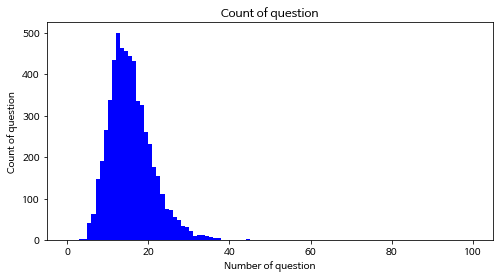

In [86]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev2_question_counts, bins=100, range=[0, 100], facecolor='b', label='dev2')
# 그래프 제목
plt.title('Count of question')
# 그래프 x 축 라벨
plt.xlabel('Number of question')
# 그래프 y 축 라벨
plt.ylabel('Count of question')
plt.show()

In [87]:
# 데이터 길이
print(f"question 길이 최대:    {np.max(dev2_question_counts):4d}")
print(f"question 길이 최소:    {np.min(dev2_question_counts):4d}")
print(f"question 길이 평균:    {np.mean(dev2_question_counts):7.2f}")
print(f"question 길이 표준편차: {np.std(dev2_question_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev2_question_counts, 25)
percentile50 = np.percentile(dev2_question_counts, 50)
percentile75 = np.percentile(dev2_question_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"question 25/100분위:  {percentile25:7.2f}")
print(f"question 50/100분위:  {percentile50:7.2f}")
print(f"question 75/100분위:  {percentile75:7.2f}")
print(f"question IQR:        {percentileIQR:7.2f}")
print(f"question MAX/100분위: {percentileMAX:7.2f}")

question 길이 최대:      45
question 길이 최소:       3
question 길이 평균:      15.15
question 길이 표준편차:    5.33
question 25/100분위:    11.00
question 50/100분위:    14.00
question 75/100분위:    18.00
question IQR:           7.00
question MAX/100분위:   28.50


In [88]:
# token count
dev2_context_counts = [len(context) for context in contexts]
dev2_context_counts[:10]

[207, 207, 207, 207, 207, 207, 207, 204, 204, 204]

#### 데이터 분석 : Context

In [89]:
# token count
dev2_context_counts = [len(context) for context in contexts]
dev2_context_counts[:10]

[207, 207, 207, 207, 207, 207, 207, 204, 204, 204]

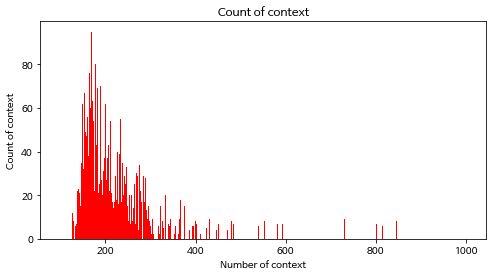

In [90]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev2_context_counts, bins=900, range=[100, 1000], facecolor='r', label='dev2')
# 그래프 제목
plt.title('Count of context')
# 그래프 x 축 라벨
plt.xlabel('Number of context')
# 그래프 y 축 라벨
plt.ylabel('Count of context')
plt.show()

In [91]:
# 데이터 길이
print(f"context 길이 최대:    {np.max(dev2_context_counts):4d}")
print(f"context 길이 최소:    {np.min(dev2_context_counts):4d}")
print(f"context 길이 평균:    {np.mean(dev2_context_counts):7.2f}")
print(f"context 길이 표준편차: {np.std(dev2_context_counts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev2_context_counts, 25)
percentile50 = np.percentile(dev2_context_counts, 50)
percentile75 = np.percentile(dev2_context_counts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"context 25/100분위:  {percentile25:7.2f}")
print(f"context 50/100분위:  {percentile50:7.2f}")
print(f"context 75/100분위:  {percentile75:7.2f}")
print(f"context IQR:        {percentileIQR:7.2f}")
print(f"context MAX/100분위: {percentileMAX:7.2f}")

context 길이 최대:    1226
context 길이 최소:     127
context 길이 평균:     231.85
context 길이 표준편차:  117.01
context 25/100분위:   169.00
context 50/100분위:   199.00
context 75/100분위:   250.00
context IQR:          81.00
context MAX/100분위:  371.50


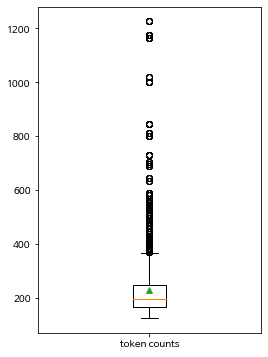

In [92]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(dev2_context_counts, labels=['token counts'], showmeans=True)
plt.show()

#### 데이터 분석 : Answer

In [93]:
# token count
dev2_answer_starts = token_starts
dev2_answer_starts[:10]

[0, 59, 0, 160, 199, 39, 6, 46, 34, 88]

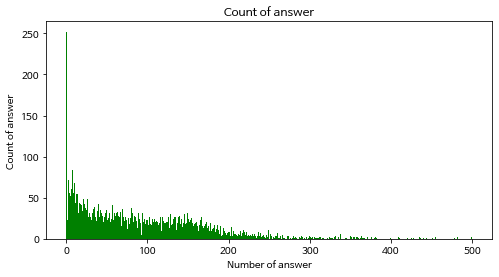

In [94]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(dev2_answer_starts, bins=500, range=[0, 500], facecolor='g', label='dev2')
# 그래프 제목
plt.title('Count of answer')
# 그래프 x 축 라벨
plt.xlabel('Number of answer')
# 그래프 y 축 라벨
plt.ylabel('Count of answer')
plt.show()

In [95]:
# 데이터 길이
print(f"answer 위치 최대:    {np.max(dev2_answer_starts):4d}")
print(f"answer 위치 최소:    {np.min(dev2_answer_starts):4d}")
print(f"answer 위치 평균:    {np.mean(dev2_answer_starts):7.2f}")
print(f"answer 위치 표준편차: {np.std(dev2_answer_starts):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(dev2_answer_starts, 25)
percentile50 = np.percentile(dev2_answer_starts, 50)
percentile75 = np.percentile(dev2_answer_starts, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"answer 25/100분위:  {percentile25:7.2f}")
print(f"answer 50/100분위:  {percentile50:7.2f}")
print(f"answer 75/100분위:  {percentile75:7.2f}")
print(f"answer IQR:        {percentileIQR:7.2f}")
print(f"answer MAX/100분위: {percentileMAX:7.2f}")

answer 위치 최대:    1192
answer 위치 최소:       0
answer 위치 평균:      93.74
answer 위치 표준편차:   90.45
answer 25/100분위:    26.00
answer 50/100분위:    75.00
answer 75/100분위:   140.00
answer IQR:         114.00
answer MAX/100분위:  311.00


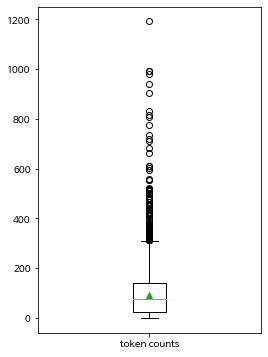

In [96]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(dev2_answer_starts, labels=['token counts'], showmeans=True)
plt.show()

## 3. 결과

#### * 모델 accuracy 결과
* pretrained model 미적용 모델 acc: 0.0172, 0.0042
* pretrained model 적용 모델 acc: 0.5732, 0.5406    

-> pretrained을 사용했을때 accuracy가 더 높고 loss가 더 낮아짐

#### * 예측 정답 결과     
질문 : 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?         
실제 정답 : 1989년 2월 15일 
* pretrained model 적용 모델 예측 정답 : 1989년 2월 15일 
* pretrained model 미적용 모델 예측 정답 : [CLS] 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배된 연도는?[SEP] 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다.1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다....생략

-> pretrained 미적용 모델보다 더욱 간략하고 정확하게 예측함을 알 수 있음


